# Probablistic model building genetic algorithm

In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import src
from src.kinetic_model import KineticModel, modelSpace_to_modelParams
from src.neural_network_builder import KineticNeuralNetworkBuilder
from src.model_spaces import get_cas9_uniform_ms, get_cas9_finkelstein_ms
from src.data import load_finkelstein_data as get_data
# reload from previous trained (already at full convergence/early stopped)
from src.reload import reload_from_dir
import amber
%matplotlib inline

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import shutil
import os
import pickle
import gc
from sklearn.model_selection import train_test_split

## Load data

In [4]:
wd = "outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA2"

target = "wtCas9_cleave_rate_log"

res = get_data(target=target, logbase=10, make_switch=wd.endswith("gRNA2"))
# unpack data tuple
(x_train, y_train), (x_test, y_test) = res

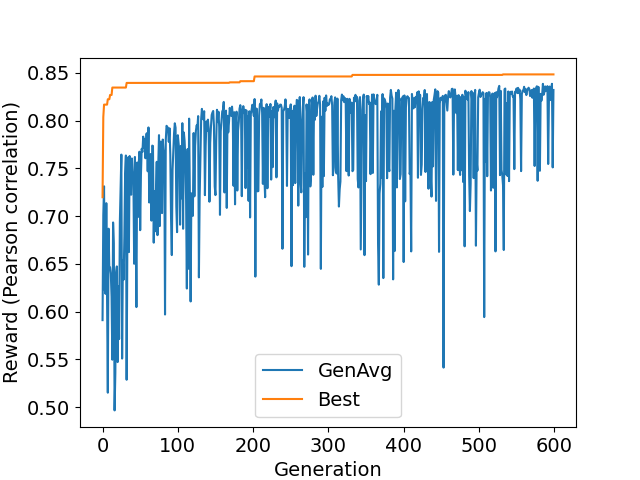

In [5]:
from IPython.display import Image

Image(filename=os.path.join(wd, "reward_vs_time.png"), width=400)

## Vis Search Stats

['outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA2/RANGE_D.png', 'outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA2/RANGE_ST.png', 'outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA2/filters.png', 'outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA2/hidden_size.png', 'outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA2/kernel_size.png', 'outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA2/reshape_fn.png']


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


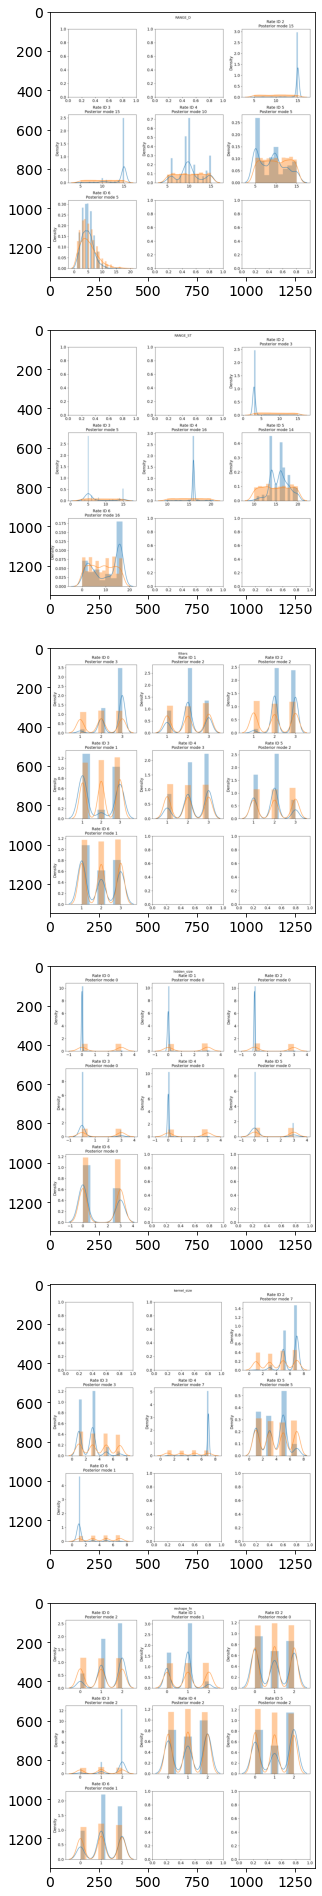

In [6]:
import matplotlib.image as mpimg

plt.figure(figsize=(40,40))
columns = 1
excl = ['reward_vs_time.png', 'test_pred.png', 'model.png']
images = [os.path.join(wd,x) for x in sorted([x for x in os.listdir(wd) \
                                                            if not x.startswith(".") and x.endswith("png") and not x in excl])]
print(images)
images = [mpimg.imread(_) for _ in images]
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

## Reload Model

In [7]:
kinn_model_space = get_cas9_finkelstein_ms()
print(kinn_model_space)

StateSpace with 7 layers and 1 total combinations


In [8]:
# manager configs
manager_kwargs={
    'output_op': 
        lambda: tf.keras.layers.Lambda(lambda x: tf.math.log(tf.clip_by_value(x, 10**-5, 10**-1))/np.log(10), name="output_log10"),  # change the clip as well
    'n_feats': 25,  # remember to change this!!
    'n_channels': 9,
}
mb = reload_from_dir(wd, manager_kwargs, model_fn=KineticNeuralNetworkBuilder)
model = mb.model

loaded searched model


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


spearman SpearmanrResult(correlation=0.7588231065296894, pvalue=0.0)
pearson (0.8495745407595539, 0.0)


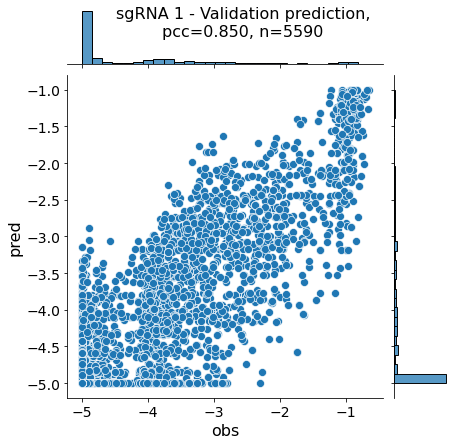

In [9]:
x_train_b = mb.blockify_seq_ohe(x_train)
x_test_b = mb.blockify_seq_ohe(x_test)

y_hat = model.predict(x_test_b).flatten()
test_pcc_old = ss.pearsonr(y_hat, y_test)[0]

h = sns.jointplot(y_test, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test))
p_old = ss.pearsonr(y_hat, y_test)
print("pearson", p_old)
h.fig.suptitle("sgRNA 1 - Validation prediction,\npcc=%.3f, n=%i"%(test_pcc_old, len(y_hat)), fontsize=16)
plt.show()


spearman SpearmanrResult(correlation=0.831097432593842, pvalue=0.0)
pearson 0.8955971117430677


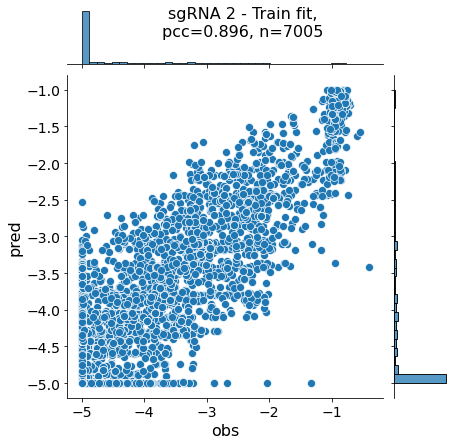

In [10]:
y_hat = model.predict(x_train_b).flatten()
test_pcc_old = ss.pearsonr(y_hat, y_train)[0]

h = sns.jointplot(y_train, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_train))
print("pearson", test_pcc_old)
h.fig.suptitle("sgRNA 2 - Train fit,\npcc=%.3f, n=%i"%(test_pcc_old, len(y_hat)), fontsize=16)
plt.show()


# Getting Kinetic Rates from the Model

In [11]:
[str(x.__dict__) for x in mb.kinn.rates]

["{'name': 'k_01', 'state_list': ['0', '1'], 'input_range': [0, 3], 'kernel_size': 3, 'scatter_nd': [((0, 0), -1), ((1, 0), 1)], 'filters': 3, 'SOURCE': '0', 'TARGET': '1', 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3, 'hidden_size': 0, 'reshape_fn': 2, 'template': None, 'mat': None}",
 "{'name': 'k_10', 'state_list': ['1', '0'], 'input_range': [0, 3], 'kernel_size': 3, 'scatter_nd': [((1, 1), -1), ((0, 1), 1)], 'filters': 2, 'SOURCE': '1', 'TARGET': '0', 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3, 'hidden_size': 0, 'reshape_fn': 0, 'template': None, 'mat': None}",
 "{'name': 'k_12', 'state_list': ['1', '2'], 'input_range': [3, 18], 'kernel_size': 3, 'scatter_nd': [((1, 1), -1), ((2, 1), 1)], 'filters': 3, 'SOURCE': '1', 'TARGET': '2', 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 3, 'RANGE_D': 15, 'hidden_size': 0, 'reshape_fn': 1, 'template': None, 'mat': None}",
 "{'name': 'k_21', 'state_list': ['2', '1'], 'input_range': [5, 20], 'kernel_size': 3, 'scatter_

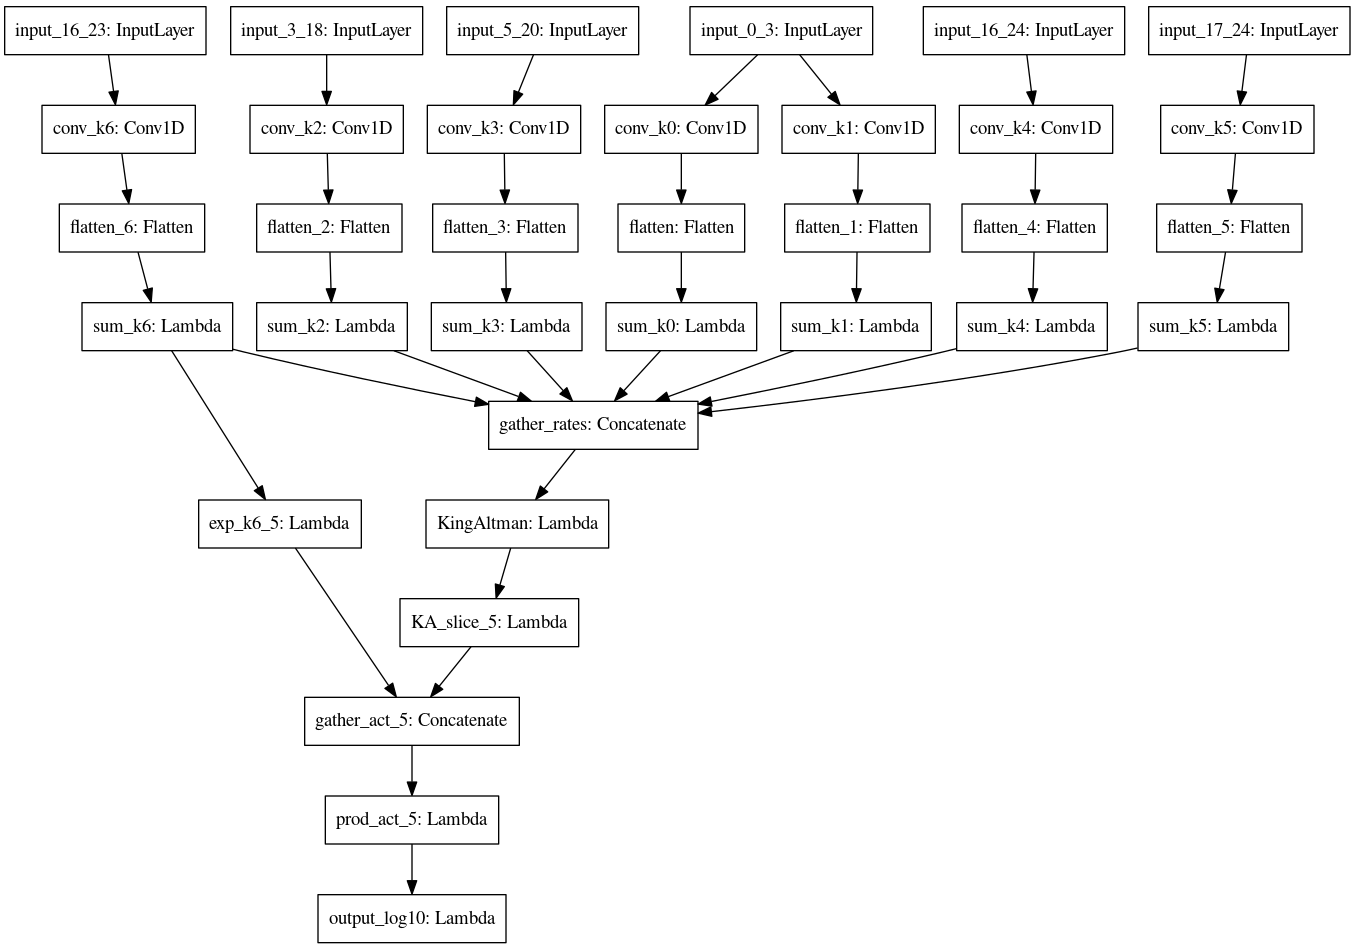

In [12]:
tf.keras.utils.plot_model(model)

In [13]:
layer_dict = {l.name:l for l in model.layers}

In [14]:
# confirmed - is aligned from rate 0 to rate N
rate_mod = tf.keras.models.Model(inputs=model.inputs, outputs=layer_dict['gather_rates'].output) 
#rate_mod = tf.keras.models.Model(inputs=model.inputs, outputs=
#                                 [layer_dict["conv_k%i"%k].output for k in range(7)])

In [15]:
outs = rate_mod.predict([x_test_b[i] for i in range(len(x_test_b))])
outs.squeeze()

array([[ -1.1694851 ,   0.88343817,  -3.4455123 , ...,   1.5516591 ,
          0.9618422 ,  -0.31172258],
       [ -1.1694851 ,   0.88343817, -10.467793  , ...,   1.5516591 ,
          0.9618422 ,  -0.31172258],
       [ -1.1694851 ,   0.88343817, -10.153942  , ...,   1.5516591 ,
          0.9618422 ,  -0.31172258],
       ...,
       [ -4.366958  ,   3.0598204 ,  -4.8361516 , ...,   1.5516591 ,
          0.9618422 ,  -0.31172258],
       [ -0.8727824 ,   0.87000096,  -4.167852  , ...,   1.5516591 ,
          0.9618422 ,  -0.31172258],
       [ -1.1694851 ,   0.88343817, -11.104144  , ...,   0.9553567 ,
          0.9618422 ,   0.47065115]], dtype=float32)

In [16]:
outs = pd.DataFrame(outs, columns=['k_%i'%i for i in range(outs.shape[1])])
outs['obs_cleavage_log10'] = y_test
outs['pred_cleavage_log10'] = model.predict(x_test_b).flatten()

In [17]:
outs.tail(10).round(3)

,k_0,k_1,k_2,k_3,k_4,k_5,k_6,obs_cleavage_log10,pred_cleavage_log10
5580,-1.169,0.883,-2.519,-1.923,0.716,2.611,0.035,-2.098,-2.363
5581,-1.169,0.883,-11.807,2.160,2.297,0.962,0.743,-5.000,-5.000
5582,-1.169,0.883,0.482,-0.280,2.907,4.545,0.916,-1.033,-1.297
5583,-1.169,0.883,-2.519,-2.072,0.716,2.581,0.035,-2.673,-2.327
5584,-1.169,0.883,-8.198,5.852,2.199,2.815,0.558,-5.000,-5.000
5585,-1.169,0.883,-10.154,2.184,1.552,0.962,-0.312,-5.000,-5.000
5586,-1.169,0.883,-3.446,-1.166,1.280,1.616,0.035,-2.773,-2.625
5587,-4.367,3.060,-4.836,2.184,1.552,0.962,-0.312,-5.000,-5.000
5588,-0.873,0.870,-4.168,-1.394,1.552,0.962,-0.312,-3.051,-2.734
5589,-1.169,0.883,-11.104,1.575,0.955,0.962,0.471,-4.990,-5.000


In [18]:
outs.to_csv(os.path.join(wd, "rates_df.tsv"), sep="\t", index=False)

In [19]:
matched = np.zeros((1,25,9))

rates = rate_mod.predict(mb.blockify_seq_ohe(matched)).flatten()
print("kinn rate for matched\n")
for i in range(7):
    r = rates[i]
    print("k_%i"%i, r)


kinn rate for matched

k_0 -1.1694851
k_1 0.88343817
k_2 0.48163795
k_3 -1.483578
k_4 1.5516591
k_5 0.9618422
k_6 -0.31172258


<AxesSubplot:title={'center':'Reverse'}>

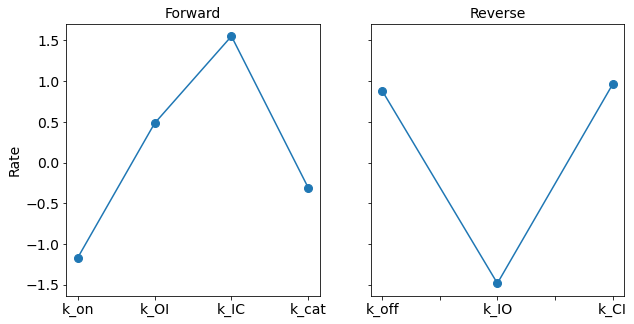

In [20]:
rate_names = ['k_on', 'k_off', 'k_OI', 'k_IO', 'k_IC', 'k_CI', 'k_cat']
rate_df = pd.DataFrame({'rate': rates}, index=rate_names)
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
rate_df.loc[['k_on', 'k_OI', 'k_IC', 'k_cat']].plot(ax=axs[0], legend=False, style='-o', title="Forward", 
                                                    ylabel="Rate")
rate_df.loc[['k_off', 'k_IO', 'k_CI']].plot(ax=axs[1], legend=False, style='-o', title="Reverse")
#axs[0].set_ylim(0,7)

# make predictions on better annotated dataframes

In [21]:
from src.crispr_kinn_predict import get_letter_index, featurize_alignment, make_alignment

In [22]:
df1 = pd.read_csv("./data/sgRNA_1.csv")
df2 = pd.read_csv("./data/sgRNA_2.csv")
df1 = df1.dropna()
df2 = df2.dropna()
cl_cols = ['wtCas9_cleave_rate_log',]
# fix the missing log10 in raw data
df1[cl_cols] = np.log10(df1[cl_cols])

# clip at limit of detection
LOD = 1e-5
df1[cl_cols] = np.maximum(df1[cl_cols], np.log10(LOD))
df2[cl_cols] = np.maximum(df2[cl_cols], np.log10(LOD))
LOD = 1e-1
df1[cl_cols] = np.minimum(df1[cl_cols], np.log10(LOD))
df2[cl_cols] = np.minimum(df2[cl_cols], np.log10(LOD))

In [23]:
# step 1, alignment
assert df1.iloc[0]['descriptor'] == 'Matched'
alns1 = [make_alignment(ref=df1.iloc[0]['sequence'], alt=row['sequence']) for _, row in df1.iterrows()]
assert df2.iloc[0]['descriptor'] == 'Matched'
alns2 = [make_alignment(ref=df2.iloc[0]['sequence'], alt=row['sequence']) for _, row in df2.iterrows()]
# step 2, featurize
ltidx = get_letter_index()
mats1 = featurize_alignment(alns1, ltidx)
mats2 = featurize_alignment(alns2, ltidx)

In [24]:
def make_predictions(mats):
    mats_bl = mb.blockify_seq_ohe(mats)
    preds = mb.model.predict(mats_bl)
    int_rates = rate_mod.predict(mats_bl)
    pred_rates = pd.DataFrame(np.hstack([preds, int_rates]), columns=['pred_cleave_rate_log10'] + rate_names)
    return pred_rates

In [25]:
cols_to_keep = ['sequence', 'descriptor', 'wtCas9_ndABA', 'wtCas9_ndABA_unc', 
                'wtCas9_cleave_rate_log', 'wtCas9_cleave_rate_log_unc']
p1 = make_predictions(mats1)
# need to reset_index to compensate for dropna
df1_pred = pd.concat([df1[cols_to_keep].reset_index(), p1], axis=1).drop(columns='index')
p2 = make_predictions(mats2)
df2_pred = pd.concat([df2[cols_to_keep].reset_index(), p2], axis=1).drop(columns='index')

In [26]:
# write out
print(wd)
df1_pred.to_csv(os.path.join(wd, "AnnotatedRatesDf-sgRNA1.tsv"), sep="\t", index=False)
df2_pred.to_csv(os.path.join(wd, "AnnotatedRatesDf-sgRNA2.tsv"), sep="\t", index=False)

outputs/2022-05-21/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA2


# Other performance measurement

spearman SpearmanrResult(correlation=0.7506005010990173, pvalue=1.7038939842403934e-253)
pearson (0.8379598234733953, 0.0)


Text(0.5, 0.98, 'sgRNA 1 Held-out Test prediction,\npcc=0.838, n=1398')

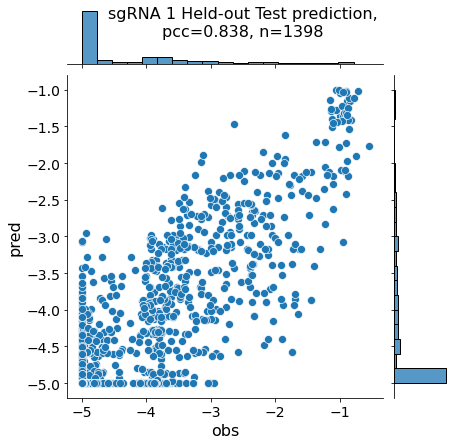

In [27]:
x_ext, y_ext = get_data(target=target, logbase=10, make_switch=wd.endswith("gRNA2"), return_remainder=True)
x_ext_b = mb.blockify_seq_ohe(x_ext)
y_ext_hat = model.predict(x_ext_b).flatten()

h = sns.jointplot(y_ext, y_ext_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_ext_hat, y_ext))
p = ss.pearsonr(y_ext_hat, y_ext)
print("pearson", p)
h.fig.suptitle("sgRNA 1 Held-out Test prediction,\npcc=%.3f, n=%i"%(p[0], len(x_ext)), fontsize=16)

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Aug 30 2022

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

matplotlib: 3.4.3
numpy     : 1.21.6
amber     : 0.1.2
scipy     : 1.7.3
src       : 0.0.1
pandas    : 1.3.5
tensorflow: 1.15.0
seaborn   : 0.11.1

Watermark: 2.3.1

